# <center>ДЗ по лекции 9: Автокодировщики

### 1. Обучить многослойный автокодировщик:   
а. отрисовать классы в латентном представлении автокодировщика с двумерным латентным слоем,   
б. сделать tSNE над 32-мерным латентным слоем.   

### 2. Обучить автокодировщик с шумом:   
а. Добавить ко входным данным нормальный шум,   
б. Сделать отражение части изображения,   
в. Визуализировать веса первого внутреннего слоя (кодирующего, get_weights, plot_mnist).

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir('drive/My Drive/Colab Notebooks/neural_OTUS')

## <center>1.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist, mnist_transform
import numpy as np

%matplotlib inline

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])

train_loader, test_loader = mnist(batch_size=200, valid=0, transform=mnist_transform)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Создаем необходимые классы

In [ ]:
class Encoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(28*28, latent_size)
    
    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        return x
    
class Decoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_size, 28*28)
    
    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        return x

In [ ]:
class Net(nn.Module):
    def __init__(self, latent_size=10, loss_fn=F.mse_loss, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.latent_size = latent_size
        self.E = Encoder(latent_size).to(device)
        self.D = Decoder(latent_size).to(device)
        self.loss_fn = loss_fn
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        h = self.E(x)
        out = self.D(h)
        return out
    
    def decode(self, h):
        with torch.no_grad():
            return self.D(h)
    
    def loss(self, x, target, **kwargs):
        target = target.view(-1, 28*28)
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss

In [ ]:
def train(epoch, models, loader, log=None, noise=False, mode='crop', elementwise=False, verbose_num=1):
    train_size = len(loader.sampler)
    for batch_idx, (data, _) in enumerate(loader):
        data = data.to(device)
        if noise:
            noised = add_noise(data, mode, elementwise)
        else:
            noised = data
        
        for model in models.values():
            model = model.to(device)
            model.optim.zero_grad()
            output = model(noised)
            loss = model.loss(output, data)
            loss.backward()
            model.optim.step()
            
    if log is not None:
        for k in models:
            log[k].append(models[k]._loss)   
            
    if epoch == 1 or epoch % verbose_num == 0:
        line = 'Epoch: {} [{}]\n'.format(epoch, train_size)
        losses = '\t' + 'Train set: ' + \
                 ' '.join(['{}: loss: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        report = line + losses
        print(report)

In [ ]:
def test(epoch, models, loader, log=None, noise=False, mode='crop', elementwise=False, verbose_num=1):
    test_size = len(loader.sampler)

    test_loss = {mod_label: 0. for mod_label in models}
    with torch.no_grad():
        for data, _ in loader:
            data = data.to(device)
            if noise:
                noised = add_noise(data, mode, elementwise)
            else:
                noised = data
            
            output = {mod_label: model(noised) for mod_label, model in models.items()}
            for mod_label, model in models.items():
                test_loss[mod_label] += model.loss(output[mod_label], noised, reduction='sum').item() # sum up batch loss
    
    for k in models:
        test_loss[k] /= (test_size * 784)
        if log is not None:
            log[k].append(test_loss[k])
    
    if epoch == 1 or epoch % verbose_num == 0:
        avg_lambda = lambda l: 'loss: {:.4f}'.format(l)
        line = lambda i, l: '{}: '.format(i) + avg_lambda(l)
        
        losses = ' '.join([line(k, test_loss[k]) for k in models])
        report = '\t' + 'Test set: ' + losses   
        print(report)

#### Тренируем автокодировщики с 2- и 32-мерным латентным слоем, включая, естественно, энкодер

In [ ]:
models = {'2': Net(2), '32': Net(32)}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [12]:
%%time
for epoch in np.arange(100) + 1:
    for model in models.values():
        model.train()
    train(epoch, models, train_loader, train_log)
    for model in models.values():
        model.eval()
    test(epoch, models, test_loader, test_log)

Epoch: 1 [60000]
	Train set: 2: loss: 1.008713 32: loss: 0.392441
	Test set: 2: loss: 1.0078 32: loss: 0.4017
Epoch: 2 [60000]
	Train set: 2: loss: 0.969470 32: loss: 0.287927
	Test set: 2: loss: 0.9691 32: loss: 0.2899
Epoch: 3 [60000]
	Train set: 2: loss: 0.905785 32: loss: 0.265040
	Test set: 2: loss: 0.9080 32: loss: 0.2658
Epoch: 4 [60000]
	Train set: 2: loss: 0.836600 32: loss: 0.255986
	Test set: 2: loss: 0.8368 32: loss: 0.2513
Epoch: 5 [60000]
	Train set: 2: loss: 0.770415 32: loss: 0.240891
	Test set: 2: loss: 0.7701 32: loss: 0.2385
Epoch: 6 [60000]
	Train set: 2: loss: 0.712287 32: loss: 0.222354
	Test set: 2: loss: 0.7116 32: loss: 0.2261
Epoch: 7 [60000]
	Train set: 2: loss: 0.663179 32: loss: 0.222315
	Test set: 2: loss: 0.6617 32: loss: 0.2140
Epoch: 8 [60000]
	Train set: 2: loss: 0.620426 32: loss: 0.203435
	Test set: 2: loss: 0.6181 32: loss: 0.2023
Epoch: 9 [60000]
	Train set: 2: loss: 0.576430 32: loss: 0.184841
	Test set: 2: loss: 0.5794 32: loss: 0.1912
Epoch: 10 

#### посмотрим на кривые обучения

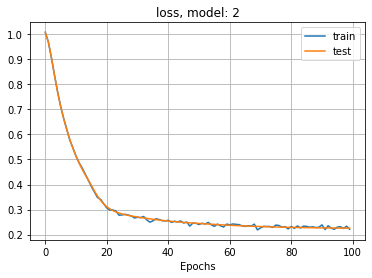

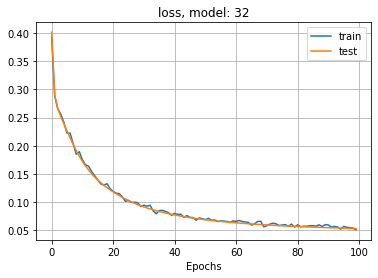

In [13]:
for model in models:
    plt.plot(train_log[model], label="train")
    plt.plot(test_log[model], label="test")
    plt.title(f"loss, model: {model}")
    plt.xlabel("Epochs")
    plt.legend()
    plt.grid()
    plt.show()

**Коммент:** модели, скорее всего, недообучены, но для наших целей уже достаточно

In [ ]:
encoders ={model: models[model].E for model in models}

#### подготовим данные для визуализации

In [ ]:
mnist_dataset = datasets.MNIST('./MNIST_data', train=True, download=True, transform=mnist_transform)

In [16]:
%%time
mnist_data = list(torch.utils.data.DataLoader(mnist_dataset, batch_size=len(mnist_dataset)))[0]
mnist_data[0].shape, mnist_data[1].shape

CPU times: user 12.3 s, sys: 297 ms, total: 12.6 s
Wall time: 12.6 s


In [ ]:
def get_latent_out_labels(encoder, mnist_data, num_samples=200):
    data, targets = mnist_data
    x = data[:num_samples].to(device)
    labels = targets[:num_samples]
    with torch.no_grad():
        x = x.view(-1, 28*28)
        latent_outs = encoder(x)
    return latent_outs, labels

#### визуализируем 2-у мерные латентные представления

In [20]:
latent_outs, labels = get_latent_out_labels(encoders["2"], mnist_data, num_samples=10000)
latent_outs.shape, labels.shape

(torch.Size([10000, 2]), torch.Size([10000]))

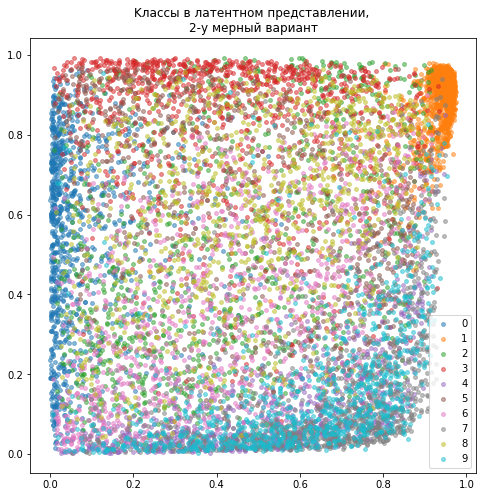

In [22]:
plt.figure(figsize=(8, 8))
for label in np.unique(labels):
    mask = (labels == label)
    plt.scatter(latent_outs[mask].cpu()[:, 0], latent_outs[mask].cpu()[:, 1], s=15, label=label, alpha=0.5)
    plt.title("Kлассы в латентном представлении, \n2-у мерный вариант")
    plt.legend()

#### визуализируем 32-у мерные латентные представления через TSNE преобразование

In [ ]:
from sklearn.manifold import TSNE

In [25]:
latent_outs32, labels32 = get_latent_out_labels(encoders["32"], mnist_data, num_samples=10000)
latent_outs32.shape, labels32.shape

(torch.Size([10000, 32]), torch.Size([10000]))

In [27]:
%%time
latent_outs32_embedded = TSNE(n_components=2).fit_transform(latent_outs32.to("cpu"))

CPU times: user 1min 50s, sys: 224 ms, total: 1min 51s
Wall time: 1min 51s


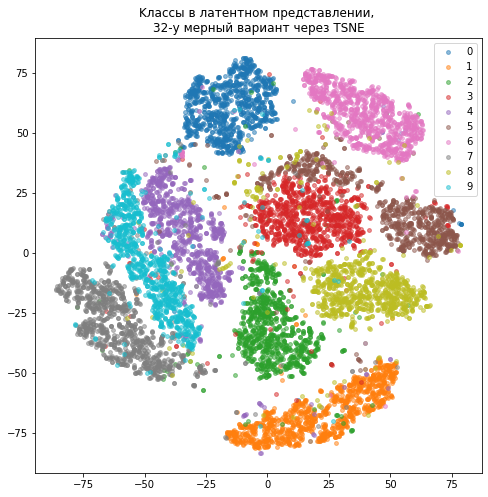

In [30]:
plt.figure(figsize=(8, 8))
for label in np.unique(labels32):
    mask = (labels32 == label)
    plt.scatter(latent_outs32_embedded[mask][:, 0], 
                latent_outs32_embedded[mask][:, 1], s=15, label=label, alpha=0.5)
    plt.title("Kлассы в латентном представлении, \n32-у мерный вариант через TSNE")
    plt.legend()

#### Коммент:
32-у мерный вариант латентного представления выглядит явно **поинтереснее**. Кроме того и лосс на кривых обучения заметно меньше, чем для 2-у мерного варианта

## <center>2.

#### делаем шум

In [47]:
data.device == torch.device("cpu")

False

In [50]:
data.device

device(type='cuda', index=0)

In [ ]:
def add_noise(x, mode='crop', elementwise=False, rand_noise=True):
    def local_mirror(area):
        dim = np.random.choice([1, 2])
        return torch.flip(area, [dim])
    
    if rand_noise:
        if np.random.randint(2):
            return x
    
    x = x.clone()
    if elementwise:
        if mode == 'crop':
            for i in range(x.shape[0]):
                img_part = np.random.randint(5)
                zero_one = np.random.randint(2)*2 - 1  # -1 or 1
                if img_part == 0:
                    x[i, :, :14, :14] = zero_one  # вторая размерность - похоже, цвет
                elif img_part == 1:
                    x[i, :, :14, 14:] = zero_one
                elif img_part == 2:
                    x[i, :, 14:, :14] = zero_one
                elif img_part == 3:
                    x[i, :, 14:, 14:] = zero_one
                elif img_part == 4:
                    x[i, :, 7:21, 7:21] = zero_one
        elif mode == 'mirror':
            for i in range(x.shape[0]):
                img_part = np.random.randint(5)
                if img_part == 0:
                    x[i, :, :14, :14] = local_mirror(x[i, :, :14, :14])
                elif img_part == 1:
                    x[i, :, :14, 14:] = local_mirror(x[i, :, :14, 14:])
                elif img_part == 2:
                    x[i, :, 14:, :14] = local_mirror(x[i, :, 14:, :14])
                elif img_part == 3:
                    x[i, :, 14:, 14:] = local_mirror(x[i, :, 14:, 14:])
                elif img_part == 4:
                    x[i, :, 7:21, 7:21] = local_mirror(x[i, :, 7:21, 7:21])
                    
        elif mode == 'gaussian':
            noise = torch.normal(0, 0.7, x.shape).to(device)
            x += noise
            
        elif mode == 'nonoise':
            pass
        
        else:
            pass
    else:
        if mode == 'crop':
            img_part = np.random.randint(5)
            zero_one = np.random.randint(2)*2 - 1
            if img_part == 0:
                x[:, :, :14, :14] = zero_one
            elif img_part == 1:
                x[:, :, :14, 14:] = zero_one
            elif img_part == 2:
                x[:, :, 14:, :14] = zero_one
            elif img_part == 3:
                x[:, :, 14:, 14:] = zero_one
            elif img_part == 4:
                x[:, :, 7:21, 7:21] = zero_one
    
    return x

#### тестируем шум

original


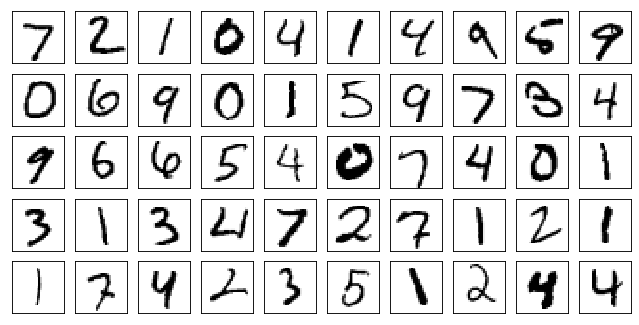

nonoise


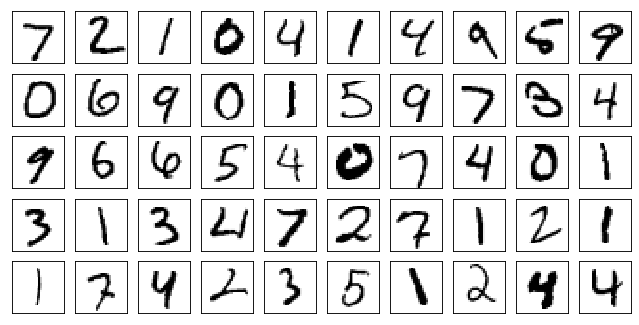

crop


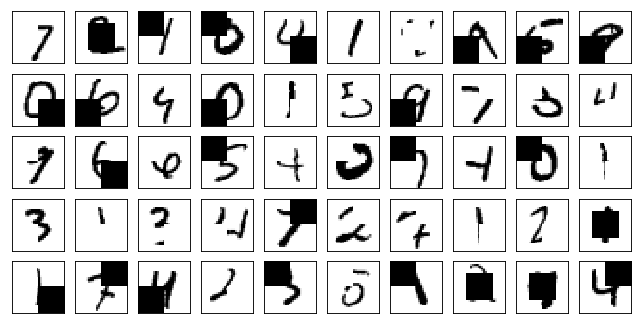

mirror


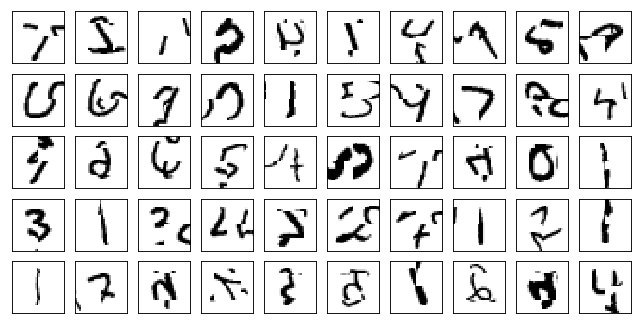

gaussian


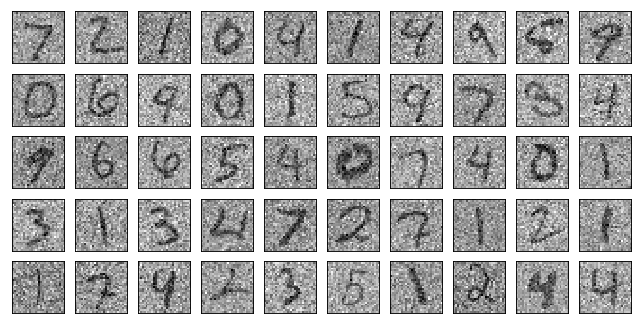

In [61]:
data, _ = next(iter(test_loader))
print("original")
plot_mnist(data.data.numpy()[:50], (5, 10))
data = data.to(device)
for mode in ["nonoise", "crop", "mirror", "gaussian"]:
    noized = add_noise(data, mode=mode, elementwise=True, rand_noise=False)
    print(mode)
    plot_mnist(noized[:50].cpu(), (5, 10))

#### обучение с шумом

In [63]:
%%time

noise_models = {}
logs = {}
noise_modes = ["nonoise", "crop", "mirror", "gaussian"]
epochs = 100

for noise_mode in noise_modes:
    noise_models[noise_mode] = {'64': Net(64)}
    logs[noise_mode] = {
        "train": {mod_label: [] for mod_label in noise_models[noise_mode]}, 
        "test": {mod_label: [] for mod_label in noise_models[noise_mode]}
    }
    print("noise_mode:", noise_mode)
    for epoch in np.arange(epochs) + 1:
        for model in noise_models[noise_mode].values():
            model.train()
        train(epoch, noise_models[noise_mode], train_loader, logs[noise_mode]["train"], 
              noise=True, mode=noise_mode, elementwise=True, verbose_num=10)
        for model in noise_models[noise_mode].values():
            model.eval()
        test(epoch, noise_models[noise_mode], test_loader, logs[noise_mode]["test"], 
             noise=True, mode=noise_mode, elementwise=True, verbose_num=10)

noise_mode: nonoise
Epoch: 1 [60000]
	Train set: 64: loss: 0.299750
	Test set: 64: loss: 0.2932
Epoch: 10 [60000]
	Train set: 64: loss: 0.123874
	Test set: 64: loss: 0.1256
Epoch: 20 [60000]
	Train set: 64: loss: 0.076425
	Test set: 64: loss: 0.0745
Epoch: 30 [60000]
	Train set: 64: loss: 0.054529
	Test set: 64: loss: 0.0530
Epoch: 40 [60000]
	Train set: 64: loss: 0.041523
	Test set: 64: loss: 0.0420
Epoch: 50 [60000]
	Train set: 64: loss: 0.036710
	Test set: 64: loss: 0.0356
Epoch: 60 [60000]
	Train set: 64: loss: 0.030127
	Test set: 64: loss: 0.0314
Epoch: 70 [60000]
	Train set: 64: loss: 0.027244
	Test set: 64: loss: 0.0285
Epoch: 80 [60000]
	Train set: 64: loss: 0.026362
	Test set: 64: loss: 0.0264
Epoch: 90 [60000]
	Train set: 64: loss: 0.027252
	Test set: 64: loss: 0.0248
Epoch: 100 [60000]
	Train set: 64: loss: 0.023322
	Test set: 64: loss: 0.0236
noise_mode: crop
Epoch: 1 [60000]
	Train set: 64: loss: 0.289485
	Test set: 64: loss: 0.3941
Epoch: 10 [60000]
	Train set: 64: loss: 

### Посмотрим на   
   - оригинальные данные
   - зашумленные входы
   - восстановленные выходы    

и сравним все это между собой 

original data


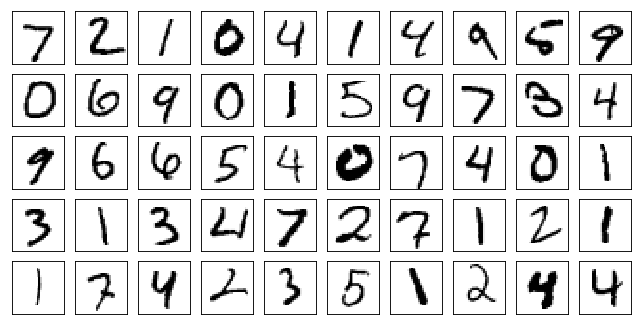

processed input: noise mode is nonoise


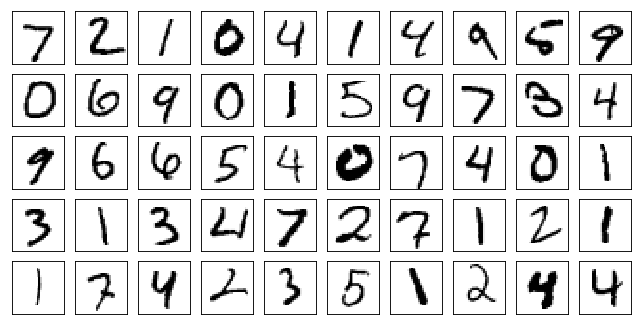

output after nonoise


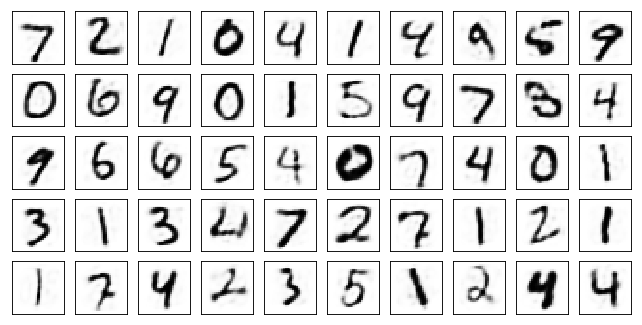

processed input: noise mode is crop


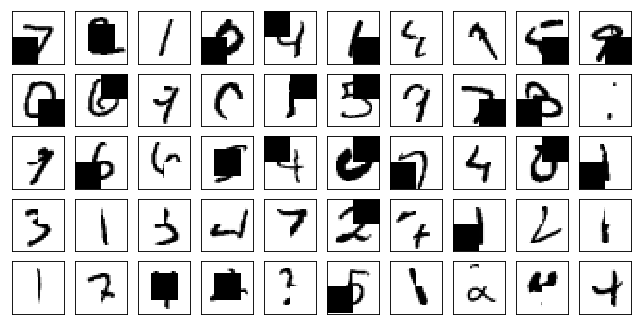

output after crop


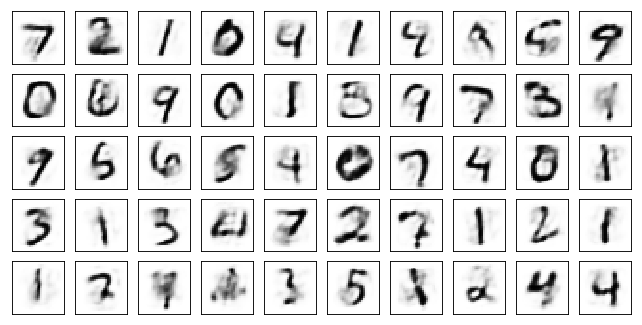

processed input: noise mode is mirror


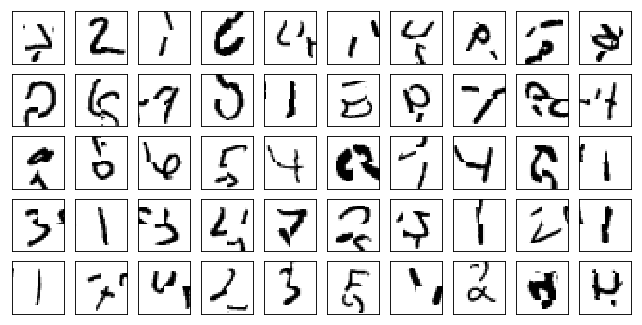

output after mirror


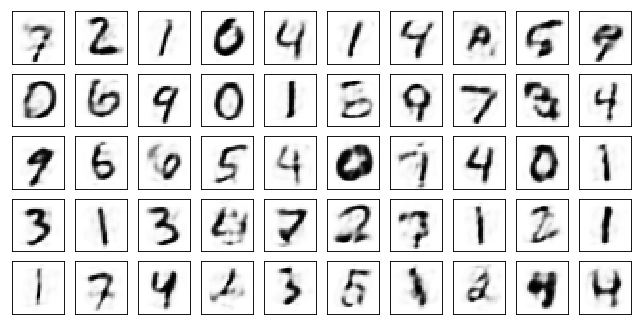

processed input: noise mode is gaussian


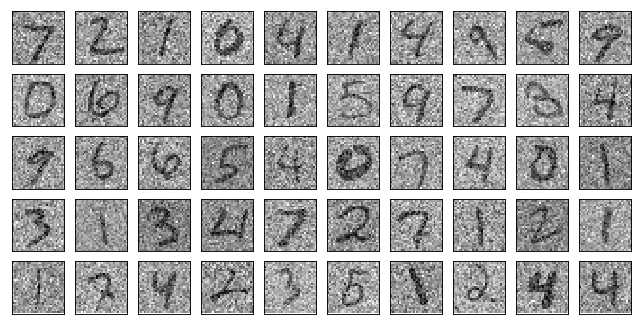

output after gaussian


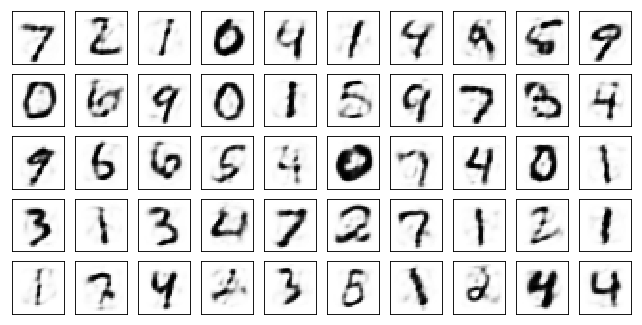

In [165]:
data, _ = next(iter(test_loader))
print("original data")
plot_mnist(data.data.numpy()[:50], (5, 10))
for noise_mode in noise_modes:
    models = noise_models[noise_mode]
    noized = add_noise(data, mode=noise_mode, elementwise=True, rand_noise=False)
    output = models['64'](noized[:50].to(device))
    to_plot = output.view(-1, 1, 28, 28).data.cpu().numpy()
    print(f"processed input: noise mode is {noise_mode}")
    plot_mnist(noized[:50], (5, 10))
    print(f"output after {noise_mode}")
    plot_mnist(to_plot, (5, 10))

### Визуализируем веса первого внутреннего слоя энкодера

nonoise


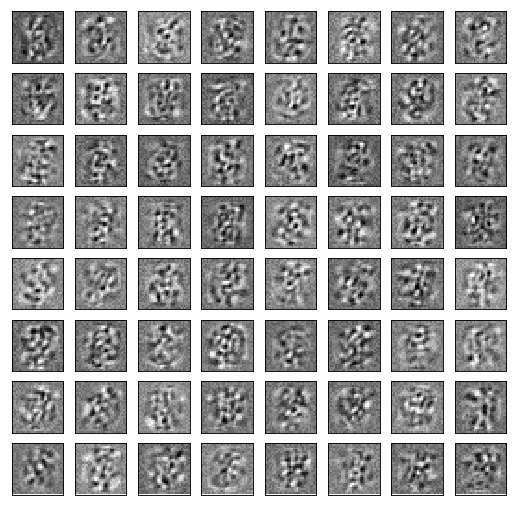

crop


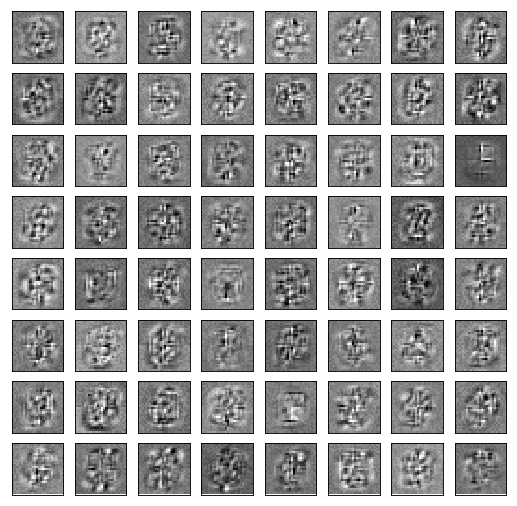

mirror


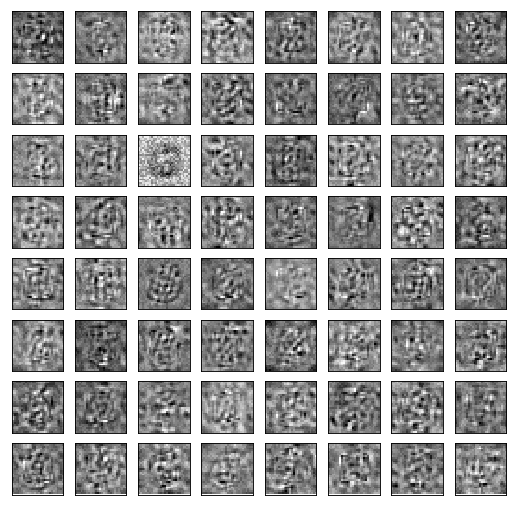

gaussian


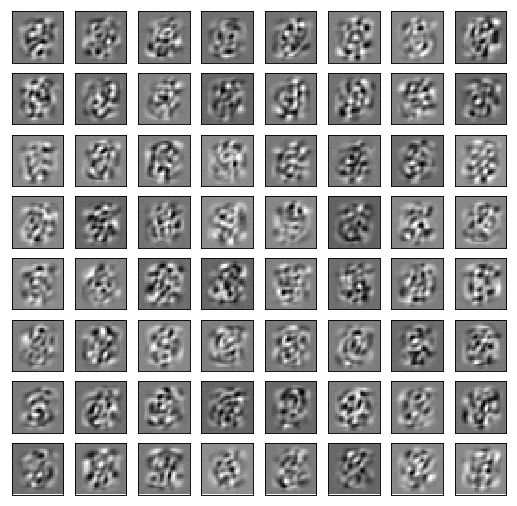

In [166]:
for noise_mode in noise_modes:
    models = noise_models[noise_mode]
    to_plot = models["64"].E.fc1.weight.data.view(-1, 1, 28, 28).cpu().numpy()
    print(noise_mode)
    plot_mnist(to_plot, (8, 8))